# Interaction term

## Intro

상호작용 변수(interaction term)과 회귀식의 관계 알아보기

## 목적

- 상호작용 변수를 회귀모형에 넣는 것이 이 데이터에 적절한지
- 상호작용 변수를 실제로 만들어보기
- 상호작용 변수가 들어간 회귀모형 해석하기

## 왜 만드는가?

* 변수 간의 상호작용을 알아보기 위해서
* 종속변수 X가 연속형 / 범주형이든 상관없이 적용할 수 있음.
* 여기에서는 연속형 1개, 범주형 1개로 시작.  

예를 들어, 이 그래프는 세개의 변수를 보여주고 있음.
- 그래프는 무게(weight)와 엔진의 기통수(cylinders)에 따른 연비(mpg)를 보여주고 있음.
- `weight`는 x축, `mpg`는 y축. `cylinders`는 색깔임. 
- weight를 표준화했음.

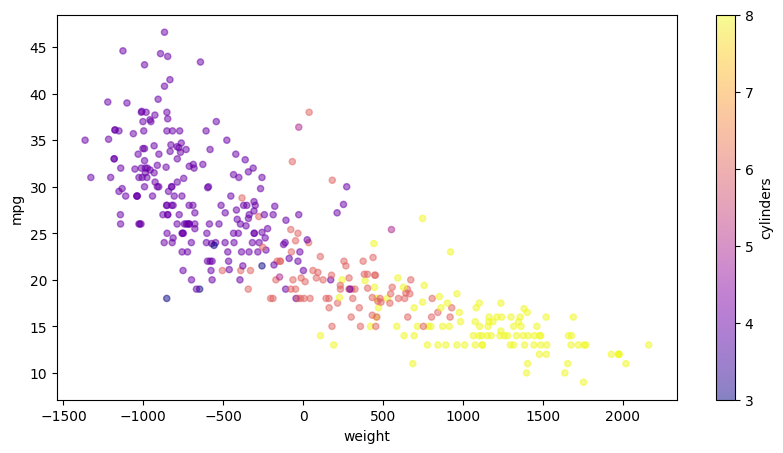

In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib nbagg
%matplotlib inline

data = pd.read_csv("../_dataset/auto-mpg.csv")
data["weight"] = data["weight"] - data["weight"].mean()
data["model year"] = data["model year"] - 70

fig, ax = plt.subplots(figsize=(10,5))
data.plot.scatter(x="weight", y="mpg", c="cylinders", cmap="plasma", alpha=0.5, ax=ax);

* `cylinders`를 범주형으로 보고, 상호작용 변수(interaction term)을 만들지 않는다고 하자.
* 이때 각 `cylinders`를 표현한 선들은 전부 평행하게 나올 것이다.

In [37]:
def plot_fit_lines(data, results, column, categories, interactions, cmap=mpl.colormaps['plasma']):
    # Extract some shorter variable names for readability
    x = data["weight"]
    beta_0 = results.params["const"]
    beta_1 = results.params["weight"]
    
    # Set up scatter plot
    fig, ax = plt.subplots(figsize=(10,5))
    data.plot.scatter(x="weight", y="mpg", c=column, cmap=cmap, alpha=0.5, ax=ax)

    colors = cmap
    min_cat = data[column].min()
    max_cat = data[column].max()
    range_cat = max_cat - min_cat
    
    # For each category, calculate and graph the fit line
    for cat in categories:
        if cat in interactions:
            fit_line = beta_0 + \
                (beta_1 + results.params[f"weight x {column}_{cat}"]) * x + \
                results.params[f"{column}_{cat}"]
        else:
            fit_line = beta_0 + beta_1 * x + results.params[f"{column}_{cat}"]
            
        ax.plot(
            x,
            fit_line,
            color=colors((cat - min_cat)/range_cat),
            label=f"{column}: {cat}",
            linewidth=5,
            alpha=0.7)

    ax.legend()

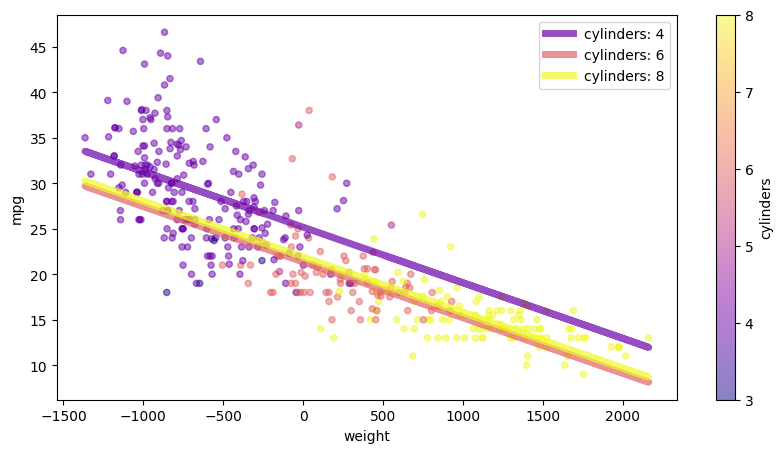

In [35]:
import statsmodels.api as sm

# Prepare data for modeling
y = data["mpg"]
X_no_interaction = data[["cylinders", "weight"]].copy()

# Create dummy variables for the 'cylinders' column
X_no_interaction = pd.get_dummies(X_no_interaction, columns=["cylinders"], drop_first=True)

# Convert the dummy variables to numeric data type
X_no_interaction = X_no_interaction.astype(float)

# Build model and get results
no_interaction_model = sm.OLS(y, sm.add_constant(X_no_interaction))
no_interaction_results = no_interaction_model.fit()

# Plot the lines generated by the model for each selected category
plot_fit_lines(data, no_interaction_results, "cylinders", [4, 6, 8], [])

**<Note>**
* 사실 실제로 자동차들은 3, 4, 5, 6, 8기통만 가지고 있다.
* 그러나, 3기통, 5기통 샘플은 너무 적기에 이를 제외함.

위 그래프를 공식으로 표현하면 다음과 같다.
$$ \large{ \text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \begin{cases}
  \beta_\text{(4 cylinders)} & \text{if 4 cylinders}, or\\
  \beta_\text{(6 cylinders)} & \text{if 6 cylinders}, or\\
  \beta_\text{(8 cylinders)} & \text{if 8 cylinders}.
\end{cases}} $$

직접 회귀선을 그렸다고 가정했을 때, 과연 저런 평행한 모양이 나올 수 있을까?
* 4기통만을 그린다고 했을때, 훨씬 더 가파른 그래프가 나올 수 밖에 없음.
* 왜? 무게가 올라갔는데, 엔진의 기통수는 그대로(=차의 힘은 그대로)이므로 연비가 떨어질 수밖에 없음
* 따라서 무게와 기통수 간의 상호작용( ***interaction term***)을 넣어줘야 좀 더 정확한 분석을 할 수 있음.

## 상호작용 더하기
* interaction term을 만들어보자. 데이터는 4기통 차량에 한정한다고 생각해보자.
* `weight` 곱하기 `cylinders_4`로 만드면 된다.
* 이때 데이터는 다음과 같이 생겼다.

In [38]:
X_no_interaction

,weight,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,526.415816,0.0,0.0,0.0,1.0
1,715.415816,0.0,0.0,0.0,1.0
2,458.415816,0.0,0.0,0.0,1.0
3,455.415816,0.0,0.0,0.0,1.0
4,471.415816,0.0,0.0,0.0,1.0
...,...,...,...,...,...
387,-187.584184,1.0,0.0,0.0,0.0
388,-847.584184,1.0,0.0,0.0,0.0
389,-682.584184,1.0,0.0,0.0,0.0
390,-352.584184,1.0,0.0,0.0,0.0


다음과 같이 상호작용 변수를 넣으면 된다.

In [39]:
X_interaction = X_no_interaction.copy()
X_interaction["weight x cylinders_4"] = X_interaction["weight"] * X_interaction["cylinders_4"]
X_interaction

,weight,cylinders_4,cylinders_5,cylinders_6,cylinders_8,weight x cylinders_4
0,526.415816,0.0,0.0,0.0,1.0,0.000000
1,715.415816,0.0,0.0,0.0,1.0,0.000000
2,458.415816,0.0,0.0,0.0,1.0,0.000000
3,455.415816,0.0,0.0,0.0,1.0,0.000000
4,471.415816,0.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...
387,-187.584184,1.0,0.0,0.0,0.0,-187.584184
388,-847.584184,1.0,0.0,0.0,0.0,-847.584184
389,-682.584184,1.0,0.0,0.0,0.0,-682.584184
390,-352.584184,1.0,0.0,0.0,0.0,-352.584184


그리고 모델을 만들고, 결과를 보면...

In [40]:
# Build model and get results
interaction_model = sm.OLS(y, sm.add_constant(X_interaction))
interaction_results = interaction_model.fit()
interaction_results.params

const                   18.243773
weight                  -0.003983
cylinders_4              5.082207
cylinders_5              9.623695
cylinders_6              2.623946
cylinders_8              1.248019
weight x cylinders_4    -0.004877
dtype: float64

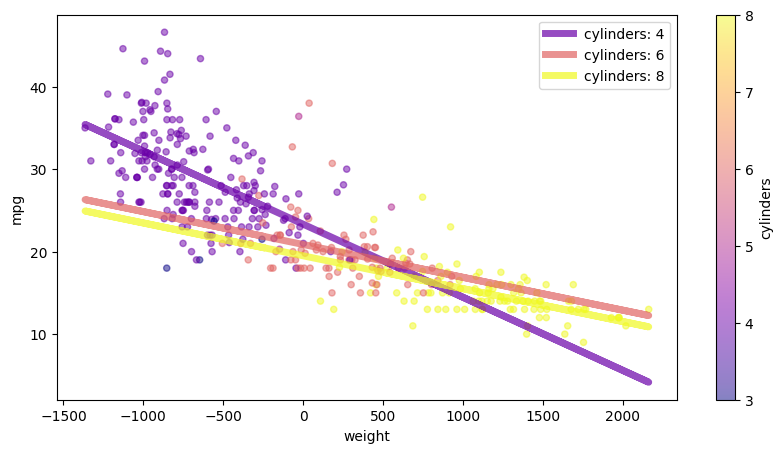

In [41]:
plot_fit_lines(data, interaction_results, "cylinders", [4, 6, 8], [4])

이를 공식으로 적어보면 다음과 같다.

$$ \large{ \text{mpg} = \beta_0 + \begin{cases}
  \beta_1 \times \text{weight} + \beta_\text{interaction} + \beta_\text{(4 cylinders)} & \text{if 4 cylinders}, or\\
  \beta_1 \times \text{weight} + \beta_\text{(6 cylinders)} & \text{if 6 cylinders}, or\\
  \beta_1 \times \text{weight} + \beta_\text{(8 cylinders)} & \text{if 8 cylinders}.
\end{cases}} $$

**<Note>**

* 여기서의 $\beta$값 : 앞의 식의 $\beta$값과 다름
* 4기통일때의 $\beta_\text{(4 cylinders)}$ 가 훨씬 더 가파름.
* 즉, 변수를 추가함으로써 모형의 추정 결과가 달라지게 됨. 

## 상호작용 변수 평가하기
* 상호작용 변수의 추가가 모델을 더 향상시켰는가?
* 상호작용 변수의 추가가 다른 정보를 더 줄 수 있는가?

> 시각화 결과가 좀 더 현실에 가까워진 것으로도 더 정보를 준다고 평가할 수 있다.  

> 그렇지만, 아직 좀 더 따져야 할 것들이 있다.

1. 상호작용 변수는 통계적으로 유의한가?
2. 상호작용 변수가 들어간 모델은 더 좋은가?

### 통계적 유의성 확인하기


In [9]:
pvalues_df = pd.DataFrame(interaction_results.pvalues, columns=["p-value"])
pvalues_df["p < 0.05"] = pvalues_df["p-value"] < 0.05
pvalues_df

,p-value,p < 0.05
const,2.832364e-17,True
weight,1.029030e-07,True
cylinders_4,1.866970e-02,True
cylinders_5,2.172974e-03,True
cylinders_6,2.216976e-01,False
cylinders_8,6.045203e-01,False
weight x cylinders_4,1.478591e-05,True


The `weight`, `cylinders_4`, **and** `weight x cylinders_4` coefficients are all statistically significant at an alpha of 0.05. This is an indicator that adding the interaction term was a good choice.

### Checking Model Metrics

Our original model had this adjusted R-Squared value:

In [10]:
no_interaction_results.rsquared_adj

np.float64(0.7213409417018846)

And our model with the interaction term had this adjusted R-Squared value:

In [11]:
interaction_results.rsquared_adj

np.float64(0.733924573658242)

Once again it appears that adding the interaction term improved the model!

## 범주형 x 수치형

Because the `const`, `cylinders_4`, `weight`, and `weight x cylinders_4` coefficients are all statistically significant, we can also interpret their meanings in the context of the model.

### Intercept Coefficients

In [12]:
interaction_results.params["const"]

np.float64(18.24377281963155)

The value shown above corresponds with $\beta_0$ in the formula shown previously. This means that ***for the reference category number of cylinders (3 in this case) and average vehicle weight, we expect to see a fuel economy of about 18 miles per gallon***.

In [13]:
interaction_results.params["cylinders_4"]

np.float64(5.082206606028953)

This value corresponds with $\beta_\text{(4 cylinders)}$. One way we could interpret it is that ***having 4 cylinders (as opposed to the reference category) is associated with an increase of about 5 mpg for a vehicle with average weight***. We also could add $\beta_0$ with $\beta_\text{(4 cylinders)}$:

In [14]:
interaction_results.params["const"] + interaction_results.params["cylinders_4"]

np.float64(23.3259794256605)

This means that ***for vehicles with 4 cylinders and average vehicle weight, we expect to see a fuel economy of about 23 miles per gallon***.

### Multiplier Coefficients

In [15]:
interaction_results.params["weight"]

np.float64(-0.003982542168115956)

The value shown above corresponds with $\beta_1$ in the formula shown previously. This means that ***for any number of cylinders other than 4*** (i.e. 3, 5, 6, or 8 cylinders) ***there is an associated decrease of about 0.004 miles per gallon for each additional pound of vehicle weight***.

In [16]:
interaction_results.params["weight x cylinders_4"]

np.float64(-0.004877195817848606)

This means that ***for vehicles with 4 cylinders, there is an additional decrease of about 0.005 in miles per gallon for each additional pound of vehicle weight, above and beyond the decrease represented by $\beta_1$***.

We can also add the interaction coefficient to the other coefficient (`weight`):

In [17]:
interaction_results.params["weight x cylinders_4"] + interaction_results.params["weight"]

np.float64(-0.008859737985964563)

This means that ***for vehicles with 4 cylinders, there is an associated decrease of about 0.009 miles per gallon for each additional pound of vehicle weight***.

Note that the larger decrease (0.009 compared to 0.004) corresponds to the steeper downward slope shown in the graph.

## Interactions with Numeric Features

It is also possible to create an interaction term between two numeric features rather than one numeric feature (e.g. `weight`) and one categorical feature (e.g. `cylinders_4`).

Let's take a look at `weight` vs. `model year`:

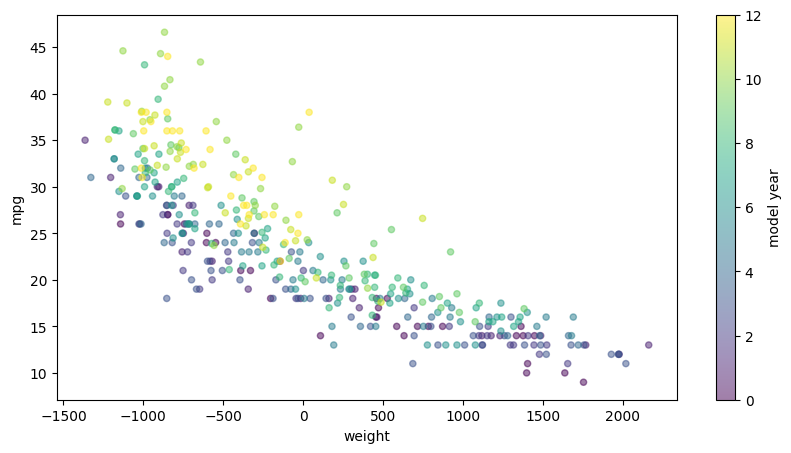

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
data.plot.scatter(x="weight", y="mpg", c="model year", cmap="viridis", alpha=0.5, ax=ax);

Just for the purposes of EDA, we could try binning the years to encode them as categorical variables, then plotting their fit lines.

In [19]:
X_many_interactions = data[["weight", "model year"]].copy()
X_many_interactions = pd.get_dummies(X_many_interactions, columns=["model year"], drop_first=True)

# skip first year value because this was dropped in one-hot encoding
years = data["model year"].unique()[1:]

for year in years:
    X_many_interactions[f"weight x model year_{year}"] = X_many_interactions["weight"] * \
                                                            X_many_interactions[f"model year_{year}"]


In [20]:
# Build model and get results
many_interactions_model = sm.OLS(y, sm.add_constant(X_many_interactions.astype(float)))
many_interactions_results = many_interactions_model.fit()

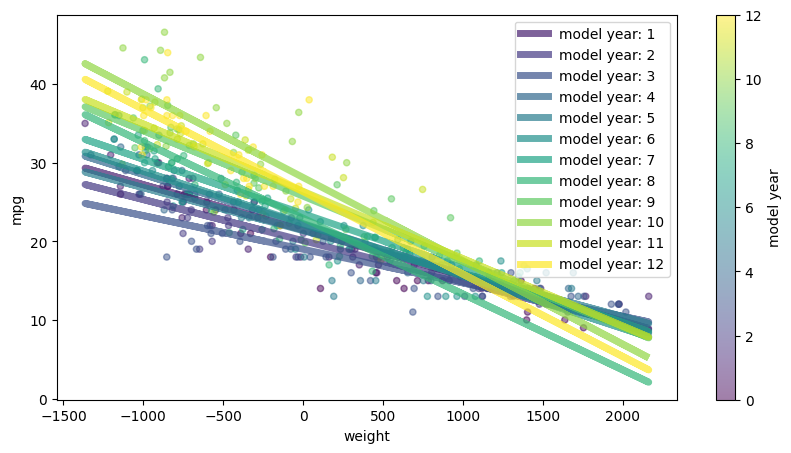

In [21]:
# Plot many fit lines
# (Remember, a model year of 1 means 1971)
plot_fit_lines(data, many_interactions_results, "model year", years, years, cmap=mpl.colormaps['viridis'])

Looking at the plot above, we can see that there is a trend of steeper slopes for later model years. So rather than treating each of these model years as a separate category, let's treat `model year` as a numeric variable and create a single interaction term `weight x model year`: 

In [22]:
# Prepare data with a single interaction term of weight x model year
X_numeric_interaction = data[["weight", "model year"]].copy()
X_numeric_interaction["weight x model_year"] = X_numeric_interaction["weight"] * X_numeric_interaction["model year"]
X_numeric_interaction

,weight,model year,weight x model_year
0,526.415816,0,0.000000
1,715.415816,0,0.000000
2,458.415816,0,0.000000
3,455.415816,0,0.000000
4,471.415816,0,0.000000
...,...,...,...
387,-187.584184,12,-2251.010204
388,-847.584184,12,-10171.010204
389,-682.584184,12,-8191.010204
390,-352.584184,12,-4231.010204


In [23]:
# Build model and get results
numeric_interaction_model = sm.OLS(y, sm.add_constant(X_numeric_interaction))
numeric_interaction_results = numeric_interaction_model.fit()

To visualize how this model works, let's look at a 3D scatter plot, with the same x-axis (`weight`) and y-axis (`mpg`) as before, this time with a z-axis showing the `model year`. This is an interactive plot, so you can click and drag to see the data from different angles!

In [24]:
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Set up 3D scatter plot
ax.scatter(
    data["weight"],      # x axis
    data["mpg"],         # y axis
    data["model year"],  # z axis
    c=data["model year"],
    cmap="viridis"
)
ax.set_xlabel("weight")
ax.set_ylabel("mpg")
ax.set_zlabel("model year");

<IPython.core.display.Javascript object>

Now we can generate a plane of weights, years, and predictions, then plot that plane on the same axes as the scatter plot.

In [25]:
import numpy as np

# Find 50 evenly-spaced points in the ranges of weight and model year and create meshes
weights = np.linspace(data["weight"].min(), data["weight"].max() + 1, 50)
years = np.linspace(data["model year"].min(), data["model year"].max() + 1, 50)
weights, years = np.meshgrid(weights, years)

# Extract relevant values from modeling results
constant = numeric_interaction_results.params["const"]
weight_coef = numeric_interaction_results.params["weight"]
year_coef = numeric_interaction_results.params["model year"]
interaction_coef = numeric_interaction_results.params["weight x model_year"]

# Make a hyperplane of predictions using the values extracted from the model
predictions = (
    # beta 0
    constant + \
    # beta 1 times weight
    weight_coef * weights + \
    # beta 2 times model year
    year_coef * years + \
    # beta 3 times weight times model year
    interaction_coef * weights * years
)

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Set up 3D scatter plot
ax.scatter(
    data["weight"],      # x axis
    data["mpg"],         # y axis
    data["model year"],  # z axis
    c=data["model year"],
    cmap="viridis"
)
ax.set_xlabel("weight")
ax.set_ylabel("model year")
ax.set_zlabel("mpg")

# Plot surface of predictions on the same axes
ax.plot_surface(
    weights,        # x
    predictions,    # y
    years,          # z
    cmap="viridis", # color is drawn from z axis value
    alpha=0.7
)

<IPython.core.display.Javascript object>

The formula being plotted here is:

$$ \large{ \text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \beta_2 \times \text{model year} + \beta_3 \times \text{weight} \times \text{model year} } $$

Note that the hyperplane is **curved** rather than a flat plane because of the interaction term.

If we just had the formula $\text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \beta_2 \times \text{model year}$ (without the interaction term) then it would have been a flat plane made up of just a straight line with a slope of $\beta_1$ along the `weight` axis and a slope of $\beta_2$ along the `model year` axis.

## 수치형 x 수치형

When both of the features used in the interaction are numeric, the interpretation is a little more tricky than with one numeric and one categorical feature. We can't just say "if `category`, there is a `coefficient` change in the target".

Instead, this kind of model is saying that the change in the target associated with the change in a given predictor is dependent on the value of another predictor!

Let's dive into some interpretations for the model shown above.

In [28]:
numeric_interaction_results.pvalues

const                  9.257577e-197
weight                  1.673750e-33
model year              1.136337e-37
weight x model_year     8.015486e-14
dtype: float64

In [29]:
numeric_interaction_results.params

const                  18.956272
weight                 -0.004509
model year              0.676944
weight x model_year    -0.000458
dtype: float64

### Intercept Coefficient

Compared to a model with categorical features, the interpretation of the intercept is fairly straightforward. The value of the `const` coefficient is about 19, which means that ***for a vehicle with average weight and a model year of 1970, we expect to see a fuel economy of about 19***.

(Remember that we subtracted the mean from `weight` and subtracted 70 from `model_year` in order to make intercepts like this more interpretable.)

### One-At-A-Time Interpretations

One way that we can interpret just the `weight` coefficient or just the `model_year` coefficient is by setting the value of the _other_ predictor to 0. That way you can ignore the `weight x model_year` beta altogether.

Thus we can say:

1. ***For a vehicle with a model year of 1970, there is a decrease of about 0.005 in mpg for each additional pound of vehicle weight.***
2. ***For a vehicle with average weight, there is an increase of about 0.7 mpg for each year newer of a model year.***

### Combined Interpretations

And what about a vehicle that does not have a model year of 1970, or is not of average weight? For that, we need to incorporate the `weight x model year` value, which is about 0.0005.

1. ***For each additional pound of vehicle weight, there is a decrease of about 0.005 + (0.0005 x model year) in mpg.***
2. ***For each year newer of a vehicle model, there is an increase of about 0.7 - (0.0005 x weight) in mpg.***

It will depend on the context whether the one-at-a-time or combined interpretation is more useful. There is a trade-off between how easy the explanation is to grasp vs. how much of the model it explains.

## 고급 : Scikit-Learn

In the examples above we used `pandas` to create the interaction terms in our dataframes. This is simple enough if you want to have relatively few interaction terms, but what if you wanted to add every single possible pairwise combination of variables? `sklearn` allows you to make lots of interaction terms at once with the `PolynomialFeatures` class and `interaction_only` parameter ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)).

In [30]:
# Prep subset of data for creating interactions
sklearn_data = data.drop("origin", axis=1).select_dtypes("number")
sklearn_data.rename(columns={"model year": "model_year"}, inplace=True)
sklearn_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
0,18.0,8,307.0,130,526.415816,12.0,0
1,15.0,8,350.0,165,715.415816,11.5,0
2,18.0,8,318.0,150,458.415816,11.0,0
3,16.0,8,304.0,150,455.415816,12.0,0
4,17.0,8,302.0,140,471.415816,10.5,0
...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,-187.584184,15.6,12
388,44.0,4,97.0,52,-847.584184,24.6,12
389,32.0,4,135.0,84,-682.584184,11.6,12
390,28.0,4,120.0,79,-352.584184,18.6,12


In [31]:
# Separate X and y
y = sklearn_data["mpg"]
X = sklearn_data.drop("mpg", axis=1)

In [32]:
from sklearn.preprocessing import PolynomialFeatures

# Fit a PolynomialFeatures transformer on X
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
poly.fit(X)

# Create transformed version of X that has all of the original features plus
# interactions between all features
new_col_names = pd.Series(poly.get_feature_names_out(X.columns)).str.replace(" ", " x ")
X_interactions = pd.DataFrame(poly.transform(X), columns=new_col_names)
X_interactions

,cylinders,displacement,horsepower,weight,acceleration,model_year,cylinders x displacement,cylinders x horsepower,cylinders x weight,cylinders x acceleration,...,displacement x horsepower,displacement x weight,displacement x acceleration,displacement x model_year,horsepower x weight,horsepower x acceleration,horsepower x model_year,weight x acceleration,weight x model_year,acceleration x model_year
0,8.0,307.0,130.0,526.415816,12.0,0.0,2456.0,1040.0,4211.326531,96.0,...,39910.0,161609.655612,3684.0,0.0,68434.056122,1560.0,0.0,6316.989796,0.000000,0.0
1,8.0,350.0,165.0,715.415816,11.5,0.0,2800.0,1320.0,5723.326531,92.0,...,57750.0,250395.535714,4025.0,0.0,118043.609694,1897.5,0.0,8227.281888,0.000000,0.0
2,8.0,318.0,150.0,458.415816,11.0,0.0,2544.0,1200.0,3667.326531,88.0,...,47700.0,145776.229592,3498.0,0.0,68762.372449,1650.0,0.0,5042.573980,0.000000,0.0
3,8.0,304.0,150.0,455.415816,12.0,0.0,2432.0,1200.0,3643.326531,96.0,...,45600.0,138446.408163,3648.0,0.0,68312.372449,1800.0,0.0,5464.989796,0.000000,0.0
4,8.0,302.0,140.0,471.415816,10.5,0.0,2416.0,1120.0,3771.326531,84.0,...,42280.0,142367.576531,3171.0,0.0,65998.214286,1470.0,0.0,4949.866071,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,4.0,140.0,86.0,-187.584184,15.6,12.0,560.0,344.0,-750.336735,62.4,...,12040.0,-26261.785714,2184.0,1680.0,-16132.239796,1341.6,1032.0,-2926.313265,-2251.010204,187.2
388,4.0,97.0,52.0,-847.584184,24.6,12.0,388.0,208.0,-3390.336735,98.4,...,5044.0,-82215.665816,2386.2,1164.0,-44074.377551,1279.2,624.0,-20850.570918,-10171.010204,295.2
389,4.0,135.0,84.0,-682.584184,11.6,12.0,540.0,336.0,-2730.336735,46.4,...,11340.0,-92148.864796,1566.0,1620.0,-57337.071429,974.4,1008.0,-7917.976531,-8191.010204,139.2
390,4.0,120.0,79.0,-352.584184,18.6,12.0,480.0,316.0,-1410.336735,74.4,...,9480.0,-42310.102041,2232.0,1440.0,-27854.150510,1469.4,948.0,-6558.065816,-4231.010204,223.2


As you might imagine, creating this many interaction terms will make the model much more difficult to interpret! Using scikit-learn like this typically only makes sense in a predictive analysis rather than an inferential one.